# Table of Contents
 <p><div class="lev1 toc-item"><a href="#r/depression:-Analysis-of-All-Reddit-Comments" data-toc-modified-id="r/depression:-Analysis-of-All-Reddit-Comments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>r/depression: Analysis of All Reddit Comments</a></div><div class="lev1 toc-item"><a href="#Dataset-Extraction-Recap" data-toc-modified-id="Dataset-Extraction-Recap-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset Extraction Recap</a></div><div class="lev1 toc-item"><a href="#Summary-Statistics" data-toc-modified-id="Summary-Statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary Statistics</a></div><div class="lev2 toc-item"><a href="#Investigation-of-data-quality-for-body" data-toc-modified-id="Investigation-of-data-quality-for-body-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Investigation of data quality for <code>body</code></a></div><div class="lev2 toc-item"><a href="#Distribution-of-Parent-IDs" data-toc-modified-id="Distribution-of-Parent-IDs-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Distribution of Parent IDs</a></div><div class="lev2 toc-item"><a href="#Distribution-of-Authors" data-toc-modified-id="Distribution-of-Authors-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Distribution of Authors</a></div><div class="lev2 toc-item"><a href="#Posting-Over-Time" data-toc-modified-id="Posting-Over-Time-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Posting Over Time</a></div><div class="lev2 toc-item"><a href="#Language" data-toc-modified-id="Language-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Language</a></div><div class="lev3 toc-item"><a href="#Distribution-of-Words" data-toc-modified-id="Distribution-of-Words-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Distribution of Words</a></div><div class="lev2 toc-item"><a href="#Score" data-toc-modified-id="Score-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Score</a></div><div class="lev2 toc-item"><a href="#Controversiality" data-toc-modified-id="Controversiality-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Controversiality</a></div><div class="lev1 toc-item"><a href="#Bivariate-Relationships" data-toc-modified-id="Bivariate-Relationships-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bivariate Relationships</a></div><div class="lev2 toc-item"><a href="#Language-Over-Time" data-toc-modified-id="Language-Over-Time-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Language Over Time</a></div><div class="lev2 toc-item"><a href="#Language-as-a-predictor-of-score" data-toc-modified-id="Language-as-a-predictor-of-score-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Language as a predictor of score</a></div>

# r/depression: Analysis of All Reddit Comments

_By [Michael Rosenberg](mailto:rosenberg.michael.m@gmail.com)._

_**Description**: Contains a short analysis of all reddit comment data that I extracted from [Google BigQuery](https://www.reddit.com/r/bigquery/comments/3cej2b/17_billion_reddit_comments_loaded_on_bigquery/)._

_Last Updated: 10/22/2017 5:40 PM EST._

In [59]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk #for relevant corpora
import collections as co #for ordered dictionary
import StringIO #for string manipulation
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.linear_model as lm
import random

#helpers
sigLev = 3
%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.precision = sigLev

In [5]:
#load in data
commentFrame = pd.read_csv("../data/raw/allRDepressionData.csv")

# Dataset Extraction Recap

We downloaded this dataset on [Google BigQuery](https://www.reddit.com/r/bigquery/comments/3cej2b/17_billion_reddit_comments_loaded_on_bigquery/) using a variant of the command found [here](../code/rDepression_all.sql). This dataset was extracted on 10/22/2017.

This is a dataset of comments from the [r/depression](https://www.reddit.com/r/depression/) page. Note that this does not contain submissions, which will be extracted from another dataset later on.

# Summary Statistics

In [11]:
commentFrame.shape

(2023603, 21)

We see that this dataset contains $2$ Million Comments. This is a large amount of text to work with, although it isn't currently clear if this is large compared to other available subreddits.

In [12]:
commentFrame.columns

Index([u'body', u'score_hidden', u'archived', u'name', u'author',
       u'author_flair_text', u'downs', u'created_utc', u'subreddit_id',
       u'link_id', u'parent_id', u'score', u'retrieved_on',
       u'controversiality', u'gilded', u'id', u'subreddit', u'ups',
       u'distinguished', u'author_flair_css_class', u'removal_reason'],
      dtype='object')

We have a few variables that are relevant here:

* `body`: The text of the comment.

* `score_hidden`: a flag indicating whether the score was hidden. Currently, it is not clear if this option is available for this subreddit.

* `archived`: a flag indicating whether the thread was archived.

* `name`: not clear what this is yet; Let's do some exploration on this.

* `author`: the username of the author who wrote the comment.

* `author_flair_text`: the flair text indicated at the bottom of the author. Currently not clear if this is useful text, but we will consider it for now.

* `downs`: The number of downs on the score of the comment. It's not clear whether this has been censored or not. We should perhaps check this in our EDA.

* `created_utc`: the creation date of the comment in coordinated universal time. We will likely need to translate this into a datetime within Pandas to interpret the timeline of these comments.

* `subreddit_id`: the ID of the subreddit the comment was placed on. Again, since all subreddits in this dataset should be `depression`, we should only have one level of `subreddit_id` in this dataset.

* `link_id`: This is the link to the entire thread, starting from the very beginning.

* `parent_id`: the ID of the item these comment is attached to. 

* `score`: The score of the comment as of 7/30/2017. My best guess is that this is the sum of upvotes and downvotes on a given comment.

* `retrieved_on`: not clear if this is when _we_ retrieve the comment or when another group of individuals have retrieved the comment._

* `constroversiality`: Some measure of how controversial a comment is. Not clear if these analytics are provided for this thread, but still useful to consider.

* `gilded`: Not clear what this is.

* `id`: ID of the comment.

* `subreddit`: This is the subreddit the comment was placed on. Currently, all subreddits in this dataset should be `depression`.

* `ups`: Number of ups on a comment. Not clear if this is provided by this thread or it is censored.

* `distinguished`: Not entirely sure what qualifies as a distinguished comment. Again, probably censored.

* `author_flair_css_class`: I guess this is the css class associated with the author flair text. Not sure if it's important to consider this when analyzing `author_flair_text`. I doubt it is.

* `removal_reason`: the reason for the removal of a particular comment. I am guessing this is a reason code that we will need to perform some lookups for to get the text-based reason for a removal. That being said, we will likely remove these types of comments from our analysis anyway.

In [13]:
#data quality check
numNullFrame = commentFrame.apply(lambda x: x[x.isnull()].shape[0],axis = 0)
numNullFrame

body                           47
score_hidden              1037364
archived                  1037364
name                      1037364
author                          0
author_flair_text         2023603
downs                     1037364
created_utc                     0
subreddit_id                    0
link_id                         0
parent_id                       0
score                           0
retrieved_on                 2767
controversiality                0
gilded                          0
id                              0
subreddit                       0
ups                        582300
distinguished             2019357
author_flair_css_class    2023603
removal_reason            2023603
dtype: int64

_Table 1: Number of Null observations in our dataset by column._

We see we have around $47$ bodies without information whatsoever. We also see sizable amount of nulls in:

* `score_hidden`

* `archived`

* `name`

* `author_flair_text`

* `downs`

* `ups`

* `distinguished`

* `author_flair_css_class`

* `removal_reason`

We see almost all observations with null counts for `author_flair_text`, `author_flair_css_class`, and `removal_reason`. For these reasons, we will remove them from the rest of our exploration.

In [14]:
#remove null bodies
filteredCommentFrame = commentFrame[commentFrame["body"].notnull()]

In [15]:
#drop  empty columns
droppedColumns = ["author_flair_text","author_flair_css_class",
                  "removal_reason"]
filteredCommentFrame = filteredCommentFrame.drop(droppedColumns,axis = 1)

In [16]:
#get number of levels
nUniqueFrame = filteredCommentFrame.apply(lambda x: x.nunique(),axis = 0)
nUniqueFrame

body                1711649
score_hidden              1
archived                  2
name                 985818
author               253371
downs                     1
created_utc         2005312
subreddit_id              1
link_id              328417
parent_id           1160632
score                   367
retrieved_on        1921960
controversiality          2
gilded                    4
id                  2021454
subreddit                 1
ups                     334
distinguished             1
dtype: int64

_Table 2: Number of Unique Levels per variable._

This provides us with quite a bit of information:

* We have many repeated types of comments. Perhaps this is part of the group that are removed from consideration.

* We have around 250K authors on this reddit. that's a rate of around $\frac{2000000}{250000} = \frac{200}{25} = 8$ comments per author. This suggest some moderate level of interaction on the site, Since I expected there to be more around $[1,2]$ comments per author.

* There are a little over $328$K unique threads. This means there tends to be fewer than $6$ comments per thread, although we will likely see more distributional inequality further in our analysis.

## Investigation of data quality for `body`

In [17]:
bodyFrame = filteredCommentFrame.groupby("body",as_index = False)[
                                                                "score"].count()
bodyFrame = bodyFrame.rename(columns = {"score":"count"})
bodyFrame = bodyFrame.sort_values("count",ascending = False)
topLev = 30
bodyFrame.iloc[0:topLev]

,body,count
1590770,[deleted],208990
1591171,[removed],55613
1186318,Thank you.,997
1162179,Thank you,846
1180368,Thank you!,594
52559,:),535
1193066,Thanks,506
1162457,Thank you :),474
1212052,Thanks!,377
1088428,Same,359


_Table 3: Top Thirty Comments by count._

We see that there are a lot of [removed] and [deleted] observations in our dataset. While I don't yet know the difference between these two, they don't really express meaningful language content with the exception of context. Thus, I think I want to remove them from consideration from the dataset.

In [18]:
filteredCommentFrame = filteredCommentFrame[~(
            filteredCommentFrame["body"].isin(["[removed]","[deleted]"]))]
filteredCommentFrame.shape

(1758953, 18)

We are now down to a little under $1.8$ millions comments.

## Distribution of  Link IDs

In [19]:
#get threads by comment count
parentFrame = filteredCommentFrame.groupby("link_id",as_index = False)[
                                                            "score"].count()
parentFrame = parentFrame.rename(columns = {"score":"count"})
parentFrame = parentFrame.sort_values("count",ascending = False)
#add rank
parentFrame["rank"] = range(parentFrame.shape[0])
#add density
parentFrame["density"] = parentFrame["count"] / parentFrame["count"].sum()
#ad log-rank
parentFrame["logRank"] = np.log(parentFrame["rank"] + 1)

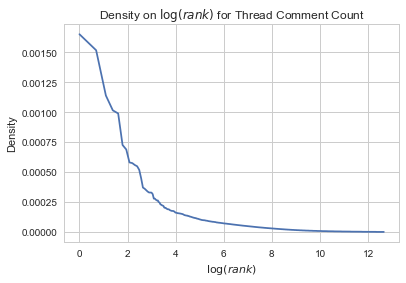

In [20]:
#then plot
plt.plot(parentFrame["logRank"],parentFrame["density"])
plt.xlabel("$\log(rank)$")
plt.ylabel("Density")
plt.title("Density on $\log(rank)$ for Thread Comment Count")

_Figure 1: Rank-Density Plot for Thread Comment Count._

We see less sparsity that we would expect. Around the top $e^{10} \approx 22000$ threads take up most of the comment distribution. This is around $6.7\%$ of the threads. Sparse, but not as bad as some distributions.

In [21]:
#get top thread ids
topLev = 10
topThreadFrame = parentFrame.iloc[0:topLev]
topThreadFrame

,link_id,count,rank,density,logRank
229942,t3_5qsba5,2903,0,1.650e-03,0.000
243471,t3_61w2k1,2668,1,1.517e-03,0.693
253725,t3_6a7gb9,2003,2,1.139e-03,1.099
96514,t3_2vv8ll,1786,3,1.015e-03,1.386
276447,t3_6swsuk,1740,4,9.892e-04,1.609
266948,t3_6lfjbt,1277,5,7.260e-04,1.792
127468,t3_3j4g0a,1211,6,6.885e-04,1.946
112306,t3_37c5fw,1021,7,5.805e-04,2.079
260481,t3_6fx6lt,1011,8,5.748e-04,2.197
13099,t3_19gu09,983,9,5.589e-04,2.303


_Table 4: Our top 10 Threads by Count._

We see the most popular parent ID is associated with a [large check-in thread](https://www.reddit.com/r/depression/comments/5qsba5). In particular, this is a weekly check-in thread that is "a place to take a moment and share what is going on and how you are doing." It started around $8$ months ago, so it's surprising how robust the comment count is for this particular thread.

We see the second most popular thread is also another [weekly check-in thread](https://www.reddit.com/r/depression/comments/61w2k1/rdepression_weekly_check_in/). It is possible that we will find many of these evident in our discourse, and they suggest an environment in which individuals are looking after one another over the internet.

## Distribution of Authors

In [22]:
#get threads by comment count
authorFrame = filteredCommentFrame.groupby("author",as_index = False)[
                                                            "score"].count()
authorFrame = authorFrame.rename(columns = {"score":"count"})
authorFrame = authorFrame.sort_values("count",ascending = False)
#add rank
authorFrame["rank"] = range(authorFrame.shape[0])
#add density
authorFrame["density"] = authorFrame["count"] / authorFrame["count"].sum()
#ad log-rank
authorFrame["logRank"] = np.log(authorFrame["rank"] + 1)

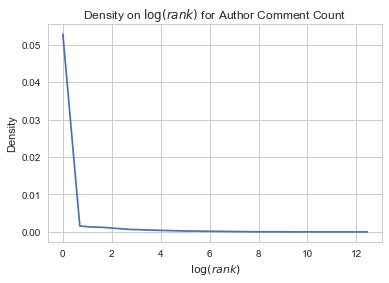

In [23]:
#then plot
plt.plot(authorFrame["logRank"],authorFrame["density"])
plt.xlabel("$\log(rank)$")
plt.ylabel("Density")
plt.title("Density on $\log(rank)$ for Author Comment Count")

_Figure 2: Authors by comment count._

We see one author hogging a huge amount of the distribution. Let's check out what this author is.

In [24]:
topAuthorFrame = authorFrame.iloc[0:topLev]
topAuthorFrame

,author,count,rank,density,logRank
116876,[deleted],92820,0,5.277e-02,0.000
87510,SQLwitch,2789,1,1.586e-03,0.693
193542,mobiuschick,2360,2,1.342e-03,1.099
222354,skyqween,2203,3,1.252e-03,1.386
196564,mytwocats11,2177,4,1.238e-03,1.609
190233,mcfattykins,2006,5,1.140e-03,1.792
13272,Bhruic,1899,6,1.080e-03,1.946
207554,poisontongue,1738,7,9.881e-04,2.079
134322,cacktastic,1637,8,9.307e-04,2.197
87345,SH2355,1546,9,8.789e-04,2.303


_Table 5: Top 10 Authors by comment count._

We see an enormous amount of observations come from deleted accounts. We can think of these as comments that are current unattributed to a particular author. While for most of our analysis, having indicators on the author likely won't matter, it will likely matter quite a bit when we do some forms of conversation modeling on our dataset.

Besides this, we see we have some commenters who exist in the $[2000,3000]$ range for number of comments. This is a sizable amount of the distribution, and suggests data sparsity in terms of the commenters that are likely to exist in the dataset.

## Posting Over Time

In [25]:
#convert from utc
filteredCommentFrame["creationDatetime"] = pd.to_datetime(
                            filteredCommentFrame["created_utc"],unit = 's')

In [26]:
filteredCommentFrame["creationDatetime"].min()

Timestamp('2009-01-01 02:14:06')

We see our earliest post in this group of comments is from $2009$. This follows with the claim on the front page of the subreddit that [it has been a community for $8$ years](https://www.reddit.com/r/depression/).

In [27]:
#just get dates
filteredCommentFrame["creationDate"] = pd.to_datetime(
                        filteredCommentFrame["creationDatetime"].dt.date)

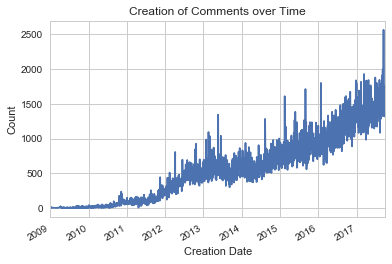

In [28]:
#then get count over time
creationDateCountSeries = filteredCommentFrame.groupby("creationDate")[
                                                                "id"].count()
creationDateCountSeries.plot()
plt.xlabel("Creation Date")
plt.ylabel("Count")
plt.title("Creation of Comments over Time")

_Figure 3: Creation of Comments Over time._

We see a gradual increase in popularity over time in the subreddit, although we see a flattening of users (and some points a decline) between $2013$ and $2015$. We should start to ask why there is a sudden uptick in the usage of the subreddit after $2015$.

It would be interesting to study if there is a seasonality uptick at particular points in the year. It is possible that seasonal affective disorder may have a relationship with thread usage.

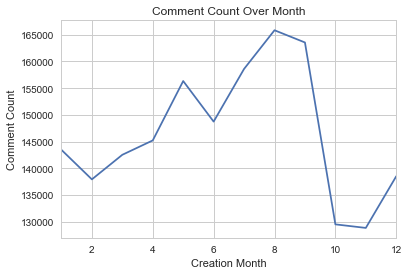

In [29]:
#get month
filteredCommentFrame["creationMonth"] = filteredCommentFrame[
                                                        "creationDate"].dt.month
#then plot
creationMonthCountSeries = filteredCommentFrame.groupby("creationMonth")[
                                                                "id"].count()
creationMonthCountSeries.plot()
plt.xlabel("Creation Month")
plt.ylabel("Comment Count")
plt.title("Comment Count Over Month")

_Figure 4: Comment Count Over Month._

We see a very interesting phenomena occuring. In particular, we see a drop in users over the winter months and a surge in users over the summer months. This may be an indication of two phenomena:

* The school season may dictate the usage of the site. In particular, at times where the school season is just starting, usage of the site tends to drop. Given the typical age of a Reddit user, I wouldn't be surprised if this effect is occuring. That being said, much of my assumptions about the age of Reddit users is informed by observation rather than by demographics.

* It is possible that we see a dip in the winter months due to seasonal affective disorder (SAD). While we would expect users with SAD to perhaps look for help during this time, it is possible that people affected by SAD are driven away from their typical behaviors during this particular timeframe.

What would be useful is to compare this seasonality to the entirety of reddit in order to validate potential effects that we see. We should also note that what I have suggested is purely conjecture as of this time; we have not performed any causal analysis to prove the above effects.

In [30]:
#check day of the week effects
filteredCommentFrame["creationDOW"] = filteredCommentFrame[
                                                    "creationDate"].dt.dayofweek

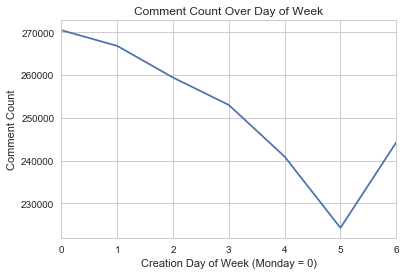

In [31]:
#then plot
creationDOWCountSeries = filteredCommentFrame.groupby("creationDOW")[
                                                                "id"].count()
creationDOWCountSeries.plot()
plt.xlabel("Creation Day of Week (Monday = 0)")
plt.ylabel("Comment Count")
plt.title("Comment Count Over Day of Week")

_Figure 5: Comment Count over Day of Week._

We see a pretty typical effect here for posting day of week. the weekdays seem to be peak times of posting, with a steady decline heading into Friday and Saturday. This is likely because people have plans over the weekend that keep them away from their computer. The population who use this subreddit don't seem to stray from typical forum norms despite my original thought that this population would be more irregular than that.

In [32]:
filteredCommentFrame["creationHour"] = filteredCommentFrame[
                                    "creationDatetime"].dt.hour

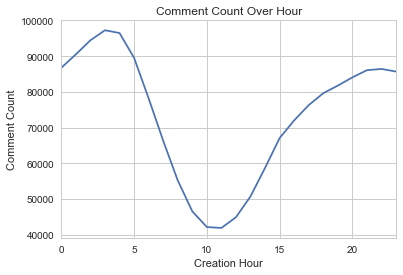

In [33]:
#then plot
creationHourCountSeries = filteredCommentFrame.groupby("creationHour")[
                                                                "id"].count()
creationHourCountSeries.plot()
plt.xlabel("Creation Hour") 
plt.ylabel("Comment Count")
plt.title("Comment Count Over Hour")

_Figure 6: Comment Count over Hour._

What becomes an issue for interpreting this plot is that it is in UTC rather than our typical EST and PST (because USA). We will note that UTC is 4 hours ahead of EST when interpreting this plot.

As expected. the very early morning hours ($6$ AM EST in particular) seem to be a low point in usage for the site, while the size looks to peak in usage from between $4$ PM and $12$ AM EST. This is expected, since the workday likely keeps individuals away from the subreddit, and then the subreddit goes back to relatively high usage when the workday is over.

## Language

Let's begin to study some of the language present in this dataset. Let's study the word distribution present in the dataset.

### Distribution of Words

In [34]:
#get all words into one long list
rawWordList = []
print(filteredCommentFrame.shape[0])
for i in xrange(filteredCommentFrame.shape[0]):
    if (i % 10000 == 0): print(i)
    tokenizedSentence = nltk.tokenize.word_tokenize(
                            filteredCommentFrame["body"].iloc[i].decode("utf8"))
    rawWordList.extend(tokenizedSentence)

1758953
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
13

In [35]:
filteredWordList = [word.lower() for word in rawWordList] #lowercase everything

In [36]:
#get legal words and get stop words
legalWordSet = set(nltk.corpus.words.words())
stopWordSet = set(nltk.corpus.stopwords.words())
#then make our filtration
filteredWordList = [word for word in filteredWordList
                           if word in legalWordSet and
                              word not in stopWordSet]

In [37]:
#create a counter
filteredWordCounter = co.Counter(filteredWordList)

In [38]:
numWords = sum(filteredWordCounter.values())
numTokens = len(filteredWordCounter.keys())

In [39]:
print(numWords)
print(numTokens)

41464906
35291


After all of our filtration to non-stop words and elgal words, we have an extremely small vocabulary. In particular, we have $42$M tokens in our sentences, but only $35$K words. Let's see what the rank distribution looks like.

In [40]:
wordFrequencyFrame = pd.DataFrame(filteredWordCounter.most_common(),
                                  columns = ["Word","Frequency"])

In [41]:
wordFrequencyFrame["Density"] = (wordFrequencyFrame["Frequency"] /
                                    sum(wordFrequencyFrame["Frequency"]))

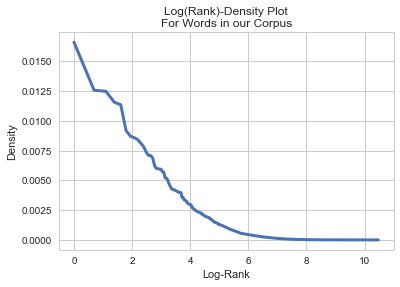

In [42]:
#then plot rank-density plot
#for the sake of easier visuals, we will log the rank
desiredLineWidth = 3
plt.plot(np.log(wordFrequencyFrame.index+1),wordFrequencyFrame["Density"],
         lw = desiredLineWidth)
plt.xlabel("Log-Rank")
plt.ylabel("Density")
plt.title("Log(Rank)-Density Plot\nFor Words in our Corpus")

_Figure 7: $\log(Rank)$-Density plot for our corpus._

As expected, we see an extremely sparse distribution. Only the top $e^6 \approx 404$ most frequent words take up the majority of the distribution. This is very typical of language, so I'm not surprised to see this result.

In [43]:
topLev = 15
topFreqFrame = wordFrequencyFrame.iloc[0:topLev,:]
topFreqFrame

,Word,Frequency,Density
0,like,688936,0.017
1,feel,521535,0.013
2,people,517888,0.012
3,get,479925,0.012
4,know,470995,0.011
5,really,381104,0.009
6,think,361188,0.009
7,life,355951,0.009
8,time,349284,0.008
9,would,336561,0.008


_Table 6: Top $15$ most frequent words in our corpus._

We see some expected words show up in the top 15, such as "depression" and "help" . However, there seems to be a focus on feelings, with words like "feel", "people", and "think" showing up as relatively common words. This suggests feelings and discussion of thoughts and feelings are important in the discussion on this subreddit.

In [44]:
#check top bigrams
#first, lowercase all of our raw words
rawWordList = [word.lower() for word in rawWordList]

In [45]:
bigrams = nltk.bigrams(rawWordList)
bigramFDist = nltk.FreqDist(bigrams)

In [46]:
bigramFrame = pd.DataFrame(list(bigramFDist.items()),
                           columns = ["Key","Frequency"])

In [47]:
bigramFrame["density"] = (bigramFrame["Frequency"] 
                          / bigramFrame["Frequency"].sum())

In [48]:
bigramFrame = bigramFrame.sort_values("density",ascending = False)

In [49]:
topLev = 15
topBigrams = bigramFrame.iloc[0:topLev,:]
topBigrams

,Key,Frequency,density
4020367,"(., i)",1682131,0.013
1155582,"(i, 'm)",707012,0.005
2969194,"(do, n't)",606620,0.005
1155630,"(it, 's)",569021,0.004
4713538,"(,, i)",524597,0.004
3604916,"(,, but)",506379,0.004
2412152,"(,, and)",493802,0.004
577180,"(., it)",420220,0.003
4947609,"(i, do)",343684,0.003
1059565,"(if, you)",315935,0.002


_Table 7: Top $15$ Bigrams in our dataset._

We see that there is little interest in the full bigram dataset. This is probably because we included stopwords in this selection for the sake of continuity.

## Score

In [50]:
filteredCommentFrame["score"].describe()

count    1.759e+06
mean     2.457e+00
std      7.449e+00
min     -1.280e+02
25%      1.000e+00
50%      1.000e+00
75%      2.000e+00
max      2.378e+03
Name: score, dtype: float64

_Table 8: Summary Statistics on score._

We see we have a large range of values for the score variable in our dataset, but relatively small variance. In particular, the average looks to be close to $2$ to $3,$ With only a standard deviation of around $7$. Let's take a look at the highest scoring and lowest scoring posts.

In [51]:
#get lowest scoring
print(filteredCommentFrame.loc[filteredCommentFrame["score"] ==
                         filteredCommentFrame["score"].min(),"body"].values)
print(filteredCommentFrame["score"].min())

[ "not at all. I'm mad because I probably won't get into an Ivy League school- seeing girls sell themselves short is just something I hate to see. I vent when I have a shitty day instead of posting a naked body for reaffirmation. Do I feel unintelligent today? Yep. Boyfriend was an asshole today and having a hard time because I got a D in organic chemistry when I'm used to A's, but that doesn't mean I'd take my frustration in my life out on someone else."]
-128


It looks like the worst rated text takes on somewhat mysoginistic tones, and looks to present somewhat of a focus on taking frustration out on one's self rather than other individuals. We would likely need to dig up the whole thread to make sense of this comment.

In [52]:
givenThread = filteredCommentFrame.loc[filteredCommentFrame["score"] ==
                filteredCommentFrame["score"].min(),"parent_id"].values[0]
givenThreadPosts = filteredCommentFrame[filteredCommentFrame["parent_id"] ==
                                        givenThread]
givenThreadPosts = givenThreadPosts.sort_values("creationDatetime")
print(givenThreadPosts["body"].values)
print(givenThread)

[ "not at all. I'm mad because I probably won't get into an Ivy League school- seeing girls sell themselves short is just something I hate to see. I vent when I have a shitty day instead of posting a naked body for reaffirmation. Do I feel unintelligent today? Yep. Boyfriend was an asshole today and having a hard time because I got a D in organic chemistry when I'm used to A's, but that doesn't mean I'd take my frustration in my life out on someone else."]
t1_cezpkvj


Upon mining, it looks like the original thread has been [removed from the site](https://www.reddit.com/r/depression/comments/cezpkvj). Thus, it would be difficult to track down the entire thread.

Let's check out the highest scoring comment.

In [53]:
print(filteredCommentFrame.loc[filteredCommentFrame["score"] ==
                         filteredCommentFrame["score"].max(),"body"].values)
print(filteredCommentFrame["score"].max())

['Happy Birthday! I hope this is a milestone of your impending greatness.']
2378


As we can tell, this has an extremely positive tone, supporting the birthday of another individual and implying that this other individual is great. It is interesting that this got so much positive feedback though; This is likely placed on a very popular thread.

## Controversiality

Based on the [current discussions on Reddit](https://www.reddit.com/r/NoStupidQuestions/comments/3xmlh8/what_does_something_being_labeled_controversial/). It looks like the controversiality of a post is dependent upon

* How many votes in total occur on the post

* How close does this post have to an equal number of ups and downs

Let's check out the distribution of this variable.

In [54]:
controversialCountFrame = filteredCommentFrame.groupby("controversiality",
                                                as_index = False)["id"].count()
controversialCountFrame = controversialCountFrame.rename(
                                                columns = {"id":"count"})
#then plot
controversialCountFrame

,controversiality,count
0,0,1756101
1,1,2852


_Table 9: Distribution of Controversiality._

We see that an extremely limited number of posts have been found to be controversial. This may make it difficult to predict, but it would be interesting to study what language informs the controversiality of a post.

# Bivariate Relationships

Let's start to take a look at the relationships between our variables.

## Language Over Time

Let's see if the distribution of language has changed much over time in an exploratory manner. In this case, we will study the top 15 works over the years.

In [ ]:
#have some helper functions
def getTopWords(givenFrame,topLev,legalWordSet,stopWordSet):
    #helper for getting the top topLev words from a givenTextFrame
    #first put all the words in a list
    rawWordList = []
    print(givenFrame.shape[0])
    for i in xrange(givenFrame.shape[0]):
        if (i % 10000 == 0): print i
        tokenizedSentence = nltk.tokenize.word_tokenize(
                            givenFrame["body"].iloc[i].decode("utf8"))
        rawWordList.extend(tokenizedSentence)
    #then do some filtrations
    filteredWordList = [word.lower() for word in rawWordList]
    filteredWordList = [word for word in filteredWordList 
                        if word in legalWordSet and word not in stopWordSet]
    #place in counter
    givenCounter = co.Counter(filteredWordList)
    #order in dataframe
    orderedWordFrame = pd.DataFrame(givenCounter.most_common(),
                                  columns = ["word","frequency"])
    orderedWordFrame["rank"] = range(orderedWordFrame.shape[0])
    topWordFrame = orderedWordFrame.iloc[0:topLev]
    return topWordFrame[["word","rank"]]

def getTopWordsInYear(givenTextFrame,year,topLev,legalWordSet,stopWordSet):
    #helper for getting top words in a given year
    givenYearFrame = givenTextFrame[givenTextFrame["creationYear"] == year]
    givenYearTopWords = getTopWords(givenYearFrame,topLev,legalWordSet,
                                    stopWordSet)
    return givenYearTopWords

In [ ]:
filteredCommentFrame["creationYear"] = (
                                filteredCommentFrame["creationDate"].dt.year)

In [ ]:
#get years
minYear = filteredCommentFrame["creationYear"].min()
maxYear = filteredCommentFrame["creationYear"].max()
yearPopularWordFrame = None
#then iterate
for year in xrange(minYear,maxYear + 1):
    topWordFrame = getTopWordsInYear(filteredCommentFrame,year,topLev,
                                     legalWordSet,stopWordSet)
    topWordFrame = topWordFrame.rename(columns = {"word":year})
    if (type(yearPopularWordFrame) == type(None)):
        yearPopularWordFrame = topWordFrame
    else:
        yearPopularWordFrame = yearPopularWordFrame.merge(topWordFrame,
                                                          on = "rank",
                                                          how = "left")

In [ ]:
yearPopularWordFrame

_Table 10: The Top 15 most popular words over the years of our dataset._

We see that most of the top vocabulary stays pretty similar over the years, although with varying popularity per word. We see that "people" and "feel" remain popular over the last few years of our dataset, although feel used to not be as popular back in in the earlier days of the subreddit. Interestingly, while Depression looks to increase in usage over time, it seems like the discussion with the word "depression" explicitly in it has declined since 2012. The word "help" looks to have a similar, if delayed, decline.

In [ ]:
def getTopWordsInPeriod(givenTextFrame,year,periodName,
                        topLev,legalWordSet,stopWordSet):
    #helper for getting top words in a given period
    givenPeriodFrame = givenTextFrame[givenTextFrame[periodName] == year]
    givenPeriodTopWords = getTopWords(givenPeriodFrame,topLev,legalWordSet,
                                      stopWordSet)
    return givenPeriodTopWords

In [ ]:
#get months
minMonth = filteredCommentFrame["creationMonth"].min()
maxMonth = filteredCommentFrame["creationMonth"].max()
monthPopularWordFrame = None
#then iterate
for month in xrange(minMonth,maxMonth + 1):
    topWordFrame = getTopWordsInPeriod(filteredCommentFrame,month,
                                       "creationMonth",
                                       topLev,legalWordSet,stopWordSet)
    topWordFrame = topWordFrame.rename(columns = {"word":month})
    if (type(monthPopularWordFrame) == type(None)):
        monthPopularWordFrame = topWordFrame
    else:
        monthPopularWordFrame = monthPopularWordFrame.merge(topWordFrame,
                                                            on = "rank",
                                                            how = "left")

In [ ]:
monthPopularWordFrame

_Table 11: Top 15 most popular words over the months._

We see that the language content does not significantly change over the months present in this dataset. We have more and more evidence that our language does not qualitatively change over time.

In [ ]:
#get months
minHour = filteredCommentFrame["creationHour"].min()
maxHour = filteredCommentFrame["creationHour"].max()
hourPopularWordFrame = None
#then iterate
for hour in xrange(minHour,maxHour + 1):
    topWordFrame = getTopWordsInPeriod(filteredCommentFrame,hour,
                                       "creationHour",
                                       topLev,legalWordSet,stopWordSet)
    topWordFrame = topWordFrame.rename(columns = {"word":hour})
    if (type(hourPopularWordFrame) == type(None)):
        hourPopularWordFrame = topWordFrame
    else:
        hourPopularWordFrame = hourPopularWordFrame.merge(topWordFrame,
                                                            on = "rank",
                                                            how = "left")

In [ ]:
numHoursInDay = 24
pd.options.display.max_columns = numHoursInDay + 1
hourPopularWordFrame

_Table 12: Top 15 words over hour of the day._

We see very little changes to the vocabulary over time when we look at  the hour context.

## Language as a predictor of score

Let's see how our language relates to score. We will predict score using an occurence vector for each document.

In [55]:
#make a vocab dictionary
counterList = filteredWordCounter.most_common()
vocabDict = {}
for i in xrange(len(counterList)):
    rankWord = counterList[i][0]
    vocabDict[rankWord] = i

In [56]:
#initialize vectorizer
vectorizer = CountVectorizer(min_df=1,stop_words=stopWordSet,
                             vocabulary = vocabDict,binary = True)
#then fit and transform our comments
bagOfOccurenceMatrix = vectorizer.fit_transform(filteredCommentFrame["body"])

In [57]:
langFrame = pd.DataFrame(bagOfOccurenceMatrix.toarray(),
                         columns = vectorizer.get_feature_names())

In [ ]:
#take a sample
rows = list(langFrame.index)
sampleSize = 100000
sampledRows = random.sample(rows,sampleSize)
sampledLangFrame = langFrame.loc[sampledRows,:]
sampledtarget = filteredCommentFrame["score"].loc[sampledRows]

In [1]:
#build model
scoreMod = lm.SGDRegressor() #feature reduction
scoreMod.fit(langFrame,filteredCommentFrame["score"])

NameError: name 'lm' is not defined

FIX:

* Fix analysis of main threads to `link_id`; `parent_id` was a different thing.